<a href="https://colab.research.google.com/github/adityaraghavan98/SHAP_tutorial/blob/main/02_SHAP_Correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SHAP Tutorial – Part 2: Correlated Features

In this notebook we explore **how feature correlation affects SHAP values**.

Goals:

- Construct a simple dataset with **strongly correlated features**  
- Fit a model and compute SHAP values  
- Observe how SHAP **redistributes importance** among correlated variables  
- Compare SHAP with a simpler measure (e.g., permutation importance, correlations)


## 1. Setup

In [ ]:
# !pip install shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

import shap

plt.rcParams["figure.figsize"] = (6, 4)

## 2. Build a correlated dataset

In this section we construct a simple 3-feature dataset designed specifically to
demonstrate how SHAP behaves when features are **strongly correlated**.

We create:

- **`x_main`** – the main driving signal  
- **`x_corr`** – a noisy copy of `x_main`  
  - making it almost interchangeable with `x_main`  
- **`x_indep`** – an unrelated feature  

The target depends primarily on the first two features:

\[
y = 3.0 $\cdot$ x_$\text{main}$ + 0.8 $\cdot$ x_$\text{corr}$ + $\epsilon$
\]

Because `x_main` and `x_corr` contain almost the same information, any model—and
any explanation method—must decide how to **assign credit** between them:

- Tree models tend to **split** credit arbitrarily  
- Linear models (especially Lasso) often pick **only one** and drop the other  
- SHAP visualizations will reflect each model’s behavior  

This tiny dataset provides a clean environment to study:

- correlation effects  
- how models divide responsibility  
- how SHAP distributes feature importance  
- why grouping correlated features is helpful  


In [ ]:
rng = np.random.default_rng(1)
n_samples = 500

x_main = rng.normal(0, 1, size=n_samples)
x_corr = x_main + rng.normal(0, 0.1, size=n_samples)  # strongly correlated
x_indep = rng.normal(0, 1, size=n_samples)

# Target depends on the sum of the first two features
y = 3.0 * (x_main + x_corr) + 0.5 * x_indep + rng.normal(0, 0.5, size=n_samples)

X = pd.DataFrame({
    "x_main": x_main,
    "x_corr": x_corr,
    "x_indep": x_indep,
})
y = pd.Series(y, name="y")

X.head()

,x_main,x_corr,x_indep
0,0.345584,0.208550,0.194840
1,0.821618,1.039178,0.838718
2,0.330437,0.191696,-0.027649
3,-1.303157,-1.410909,0.782432
4,0.905356,0.785270,-2.575443


### Check correlations

**Why check correlations?**

Before applying SHAP, it is important to verify the relationship between features.
Here we confirm that:

- `x_main` and `x_corr` are **strongly correlated**  
- `x_indep` remains independent  

This ensures that when we later see SHAP splitting, zeroing, or grouping,
we know it is due to correlation, not randomness.



In [ ]:
corr = X.corr()
corr

,x_main,x_corr,x_indep
x_main,1.000000,0.993399,0.032989
x_corr,0.993399,1.000000,0.042831
x_indep,0.032989,0.042831,1.000000


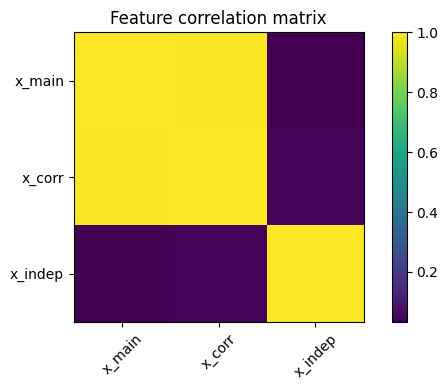

In [ ]:
plt.imshow(corr.values, interpolation="nearest")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Feature correlation matrix")
plt.colorbar()
plt.tight_layout()
plt.show()

### Interpreting the correlation matrix

This heatmap shows how similar the features are to each other:

- The bright yellow square between **`x_main`** and **`x_corr`** indicates a
  correlation very close to **1.0**, meaning the two features carry almost the
  same information.
- The dark region involving **`x_indep`** shows it is uncorrelated with the
  other two features.
- The diagonal is always 1.0 because each feature is perfectly correlated with itself.

This structure is exactly what we want for this tutorial:

- `x_main` and `x_corr` provide redundant information  
- The model must choose how to split credit between them  
- SHAP will help us understand how each model handles this redundancy


## 3. Train a model

We again use a `RandomForestRegressor` for flexibility.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

model = RandomForestRegressor(
    n_estimators=300,
    random_state=0
)
model.fit(X_train, y_train)

print("Train R^2:", model.score(X_train, y_train))
print("Test  R^2:", model.score(X_test, y_test))

Train R^2: 0.9981293319730953
Test  R^2: 0.9862998607156038


## 4. Model-based and permutation importances

We compute two baseline importance measures:

- built-in tree feature importances  
- permutation importances on the test set  

### Why compare model-based vs permutation importance?

Before introducing SHAP, it helps to see how traditional feature-importance
methods behave when features are correlated:

- **Model-based importance** (from tree splits) often “splits” credit between
  correlated features.
- **Permutation importance** measures how much the model's performance drops
  when a feature is randomized.

When two features contain the same information (`x_main` and `x_corr`), both
methods tend to give **inflated or unstable importances**, because they cannot
easily decide which feature deserves the credit.

This provides a useful baseline for understanding why SHAP's additive,
sample-level explanations offer more stability and interpretability in the
presence of correlated features.



In [ ]:
# Model-based importances
imp_model = model.feature_importances_

# Permutation importances
perm = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=0)

print("Model-based importances:")
for name, val in zip(X.columns, imp_model):
    print(f"  {name}: {val:.3f}")

print("\nPermutation importances (mean decrease in R^2):")
for name, val in zip(X.columns, perm.importances_mean):
    print(f"  {name}: {val:.3f}")

Model-based importances:
  x_main: 0.289
  x_corr: 0.704
  x_indep: 0.008

Permutation importances (mean decrease in R^2):
  x_main: 0.204
  x_corr: 0.972
  x_indep: 0.009


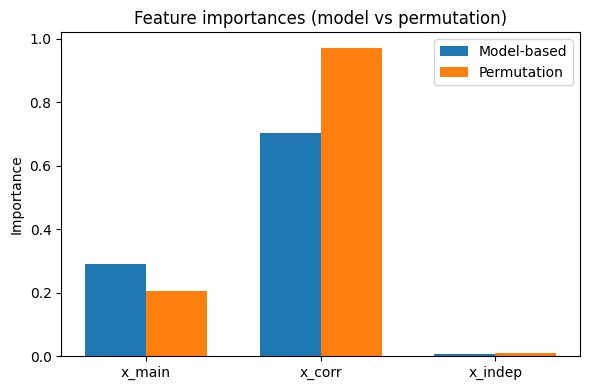

In [ ]:
# Simple bar plot comparison
x = np.arange(len(X.columns))
width = 0.35

plt.bar(x - width/2, imp_model, width, label="Model-based")
plt.bar(x + width/2, perm.importances_mean, width, label="Permutation")
plt.xticks(x, X.columns)
plt.ylabel("Importance")
plt.title("Feature importances (model vs permutation)")
plt.legend()
plt.tight_layout()
plt.show()

## 5. SHAP values under correlation

We now compute SHAP values using `TreeExplainer`. Because `x_main` and `x_corr`
are highly correlated and used together by the model, SHAP must decide how to
**share responsibility** between them.


In [ ]:
background = X_train.sample(200, random_state=0)

explainer = shap.TreeExplainer(model, data=background)
shap_values = explainer(X_test)

shap_values.values.shape

 93%|=================== | 116/125 [00:11<00:00]       

(125, 3)

### SHAP summary plot

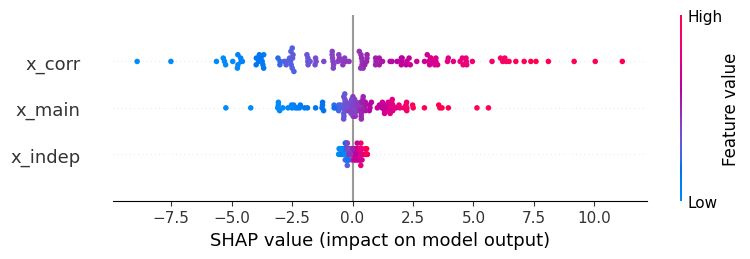

In [ ]:
shap.summary_plot(shap_values.values, X_test, feature_names=X.columns)

### Reading the SHAP summary plot

Because `x_main` and `x_corr` are correlated and both influence the target,
their SHAP points look very similar.  
`x_indep`, having no influence, stays centered around zero.

This plot confirms that SHAP correctly detects which features matter, even when
the model splits credit across correlated inputs.


### Inspect mean absolute SHAP values

We can look at the average absolute SHAP value per feature to see their
global contribution in the model.


x_main: 1.265
x_corr: 3.126
x_indep: 0.270


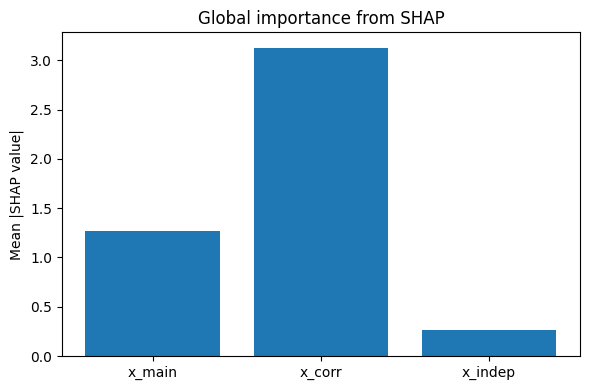

In [ ]:
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)
for name, val in zip(X.columns, mean_abs_shap):
    print(f"{name}: {val:.3f}")

plt.bar(X.columns, mean_abs_shap)
plt.ylabel("Mean |SHAP value|")
plt.title("Global importance from SHAP")
plt.tight_layout()
plt.show()

## 6. Contrast: How Linear Models Handle Correlation

So far, we have seen how tree-based models (like Random Forests) behave when two
features are highly correlated:

- They tend to **split credit arbitrarily** between correlated features.
- SHAP reflects this by dividing importance across them.

But how do **linear models** behave in the same situation?

Two common regularized linear models behave very differently:

- **Ridge Regression (L2):** spreads weights across correlated features  
- **Lasso Regression (L1):** often picks **one** correlated feature and drives the other **to zero**

Let us train a Lasso model on the same dataset and compare its SHAP explanations.


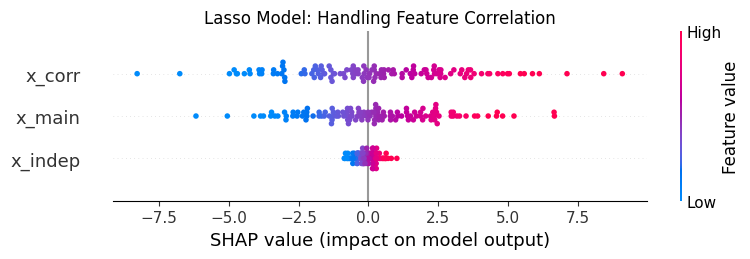

In [ ]:
from sklearn.linear_model import Lasso, Ridge

# Train a Lasso model (L1 regularization)
# Larger alpha → more aggressive shrinking → more zero coefficients
model_linear = Lasso(alpha=0.1)
model_linear.fit(X_train, y_train)

# SHAP for linear models (fast and exact)
explainer_linear = shap.LinearExplainer(model_linear, X_train)
shap_values_linear = explainer_linear(X_test)

# SHAP summary for the Lasso model
plt.title("Lasso Model: Handling Feature Correlation")
shap.summary_plot(shap_values_linear, X_test, feature_names=X.columns)


### Interpretation

Lasso tends to pick only one of the correlated features (`x_main` or `x_corr`)
and drop the other by setting its coefficient to zero.

As a result:

- SHAP assigns **all importance** to one feature  
- The other correlated feature gets **zero** importance  
- Even though both features contain the same underlying signal

This behavior is completely different from Random Forests, which tend to
**split the responsibility** between the two.

This highlights a key idea:

> SHAP reflects the model's behavior, not the true underlying data-generating process.


## 7. The Fix: Grouping Correlated Features

Because `x_main` and `x_corr` encode nearly the **same information**, treating
them as separate features can lead to confusing or unstable importance values.

A better approach is to **group** correlated features and analyze importance
at the group level.

SHAP provides a clustering utility that groups features according to their
**correlation structure**.


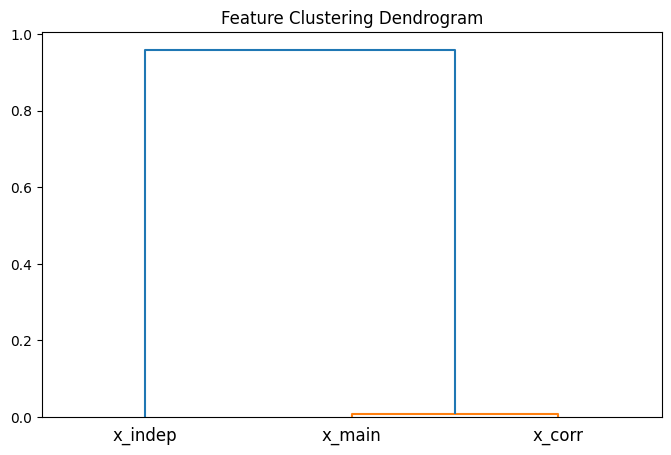

In [ ]:
import scipy.cluster.hierarchy as sch

# 1. Compute feature-feature correlations and perform hierarchical clustering
clustering = shap.utils.hclust(X, metric="correlation")

# 2. Visualize the cluster structure with a dendrogram
plt.figure(figsize=(8, 5))
sch.dendrogram(clustering, labels=X.columns, orientation="top")
plt.title("Feature Clustering Dendrogram")
plt.show()


### Insight

The dendrogram merges `x_main` and `x_corr` at the lowest level:

- This indicates that these two features are almost identical
- SHAP recognizes their similarity based on the correlation structure

In real datasets (materials science, chemistry, genomics, finance),
feature grouping is extremely useful for interpreting:

- redundant signals  
- multicollinearity  
- domain-specific feature clusters  

In practice, you can:

- **sum SHAP values** of correlated features  
- or treat the cluster as a **single meta-feature**  
- or report **group-level** contributions instead of individual ones

This avoids the misleading “importance-splitting” effect.


## 8. Try it yourself! 🎯

Here are a few simple experiments you can play with to see how different settings affect SHAP and model behavior. These small changes can make the correlation effects much more intuitive.

### 1. Change the correlation strength
In the synthetic data block, modify how similar `x_corr` is to `x_main`:

```python
x_corr = x_main * 1.0 + np.random.normal(0, 0.01, size=n_samples)   # very strong correlation
# try:
# x_corr = x_main * 0.7 + np.random.normal(0, 0.3, size=n_samples)   # weaker correlation
```

### 2. Adjust the Lasso regularization strength
```python
model_linear = Lasso(alpha=0.01)
# try alpha = 0.1, 0.5, 1.0
```

### 3. Change the depth of the tree model
```python
model = RandomForestRegressor(max_depth=3)
# try max_depth=2, 5, None
```

### 4. Add a completely irrelevant feature
```python
X["x_noise"] = np.random.normal(0, 1, size=n_samples)
```

### 5. Make the target slightly nonlinear
```python
y = 3.0*x_main + 0.8*x_corr + 0.3*np.sin(4*x_main) + noise
```

### 6. Try grouping features manually
```python
shap_group = shap_values.values[:, 0] + shap_values.values[:, 1]
```

